<a id='Top'></a>

# Multisurv model training<a class='tocSkip'></a>

Train MultiSurv models with different combinations of input data modalities.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import sys
import os

import ipywidgets as widgets
import pandas as pd
import torch

if torch.cuda.is_available():
    print('>>> PyTorch detected CUDA <<<')

# Make modules in "src" dir visible
if os.getcwd() not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'src'))

import utils
from model import Model

>>> PyTorch detected CUDA <<<


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DataLoader" data-toc-modified-id="DataLoader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><code>DataLoader</code></a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Different-intervals" data-toc-modified-id="Different-intervals-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Different intervals</a></span><ul class="toc-item"><li><span><a href="#Equidistant-times" data-toc-modified-id="Equidistant-times-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Equidistant times</a></span></li><li><span><a href="#By-duration-quantiles" data-toc-modified-id="By-duration-quantiles-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>By duration quantiles</a></span></li></ul></li><li><span><a href="#Pick-learning-rate" data-toc-modified-id="Pick-learning-rate-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pick learning rate</a></span></li><li><span><a href="#Fit" data-toc-modified-id="Fit-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Fit</a></span><ul class="toc-item"><li><span><a href="#Save-model-weights" data-toc-modified-id="Save-model-weights-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Save model weights</a></span></li></ul></li><li><span><a href="#Check-validation-metrics" data-toc-modified-id="Check-validation-metrics-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Check validation metrics</a></span></li></ul></li></ul></div>

In [2]:
DATA = utils.INPUT_DATA_DIR
MODELS = utils.TRAINED_MODEL_DIR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# `DataLoader`

In [3]:
data_modalities = widgets.SelectMultiple(
    options=['clinical', 'mRNA', 'DNAm', 'miRNA', 'CNV', 'wsi'],
    index=[0, 1],
    rows=6,
    description='Input data',
    disabled=False
)
display(data_modalities)

SelectMultiple(description='Input data', index=(0, 1), options=('clinical', 'mRNA', 'DNAm', 'miRNA', 'CNV', 'w…

In [4]:
dataloaders = utils.get_dataloaders(data_location=DATA,
                                    labels_file='data/labels.tsv',
                                    modalities=data_modalities.value,
                                    wsi_patch_size=299,
                                    n_wsi_patches=5,
#                                     batch_size=20,
#                                     batch_size=64,
#                                     batch_size=32,
#                                     exclude_patients=exclude_cancers,
                                   )

Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 1092

Batch size: 128


# Model

## Different intervals

If trying out different time interval outputs.

### Equidistant times

### By duration quantiles

In [5]:
multisurv = Model(dataloaders=dataloaders,
#                   fusion_method='attention',
#                   output_intervals=interval_cuts,
                  device=device)

Instantiating MultiSurv model...


In [6]:
print('Output intervals (in years):')
multisurv.output_intervals / 365

Output intervals (in years):


tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30.])

In [7]:
multisurv.model_blocks

['clinical_submodel', 'mRNA_submodel', 'aggregator', 'fc_block', 'risk_layer']

In [8]:
print('Trainable blocks:')
layer = None

for name, child in multisurv.model.named_children():
    for name_2, params in child.named_parameters():
        if name is not layer:
            print(f'   {name}: {params.requires_grad}')
        layer = name

Trainable blocks:
   clinical_submodel: True
   mRNA_submodel: True
   fc_block: True
   risk_layer: True


In [9]:
multisurv.model

MultiSurv(
  (clinical_submodel): ClinicalNet(
    (embedding_layers): ModuleList(
      (0): Embedding(33, 17)
      (1): Embedding(2, 1)
      (2): Embedding(8, 4)
      (3): Embedding(3, 2)
      (4): Embedding(3, 2)
      (5): Embedding(3, 2)
      (6): Embedding(3, 2)
      (7): Embedding(3, 2)
      (8): Embedding(20, 10)
    )
    (linear): Linear(in_features=43, out_features=256, bias=True)
    (embedding_dropout): Dropout(p=0.5, inplace=False)
    (bn_layer): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (output_layer): FC(
      (fc): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Linear(in_features=256, out_features=512, bias=True)
        (2): ReLU(inplace=True)
      )
    )
  )
  (mRNA_submodel): FC(
    (fc): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=1000, out_features=2048, bias=True)
      (2): ReLU(inplace=True)
      (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affin

## Pick learning rate

In [10]:
%%time

multisurv.test_lr_range()
print()

Instantiating MultiSurv model...
>>> Compute loss at increasing LR values
    Iterate over mini-batches: 69
    Completed test.

CPU times: user 4.46 s, sys: 193 ms, total: 4.65 s
Wall time: 2min 55s


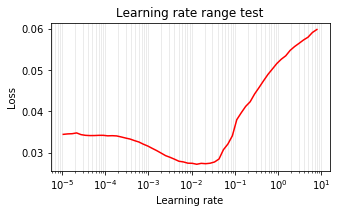

In [11]:
multisurv.plot_lr_range(trim=1)

## Fit

In [15]:
picked_lr = 5e-3

run_tag = utils.compose_run_tag(model=multisurv, lr=picked_lr,
                                dataloaders=dataloaders,
                                log_dir='.training_logs/',
                                suffix='')

Run tag: "clinical_mRNA_lr0.005_"


In [16]:
fit_args = {
    'lr': picked_lr,
    'num_epochs': 75,
    'info_freq': 5,
#     'info_freq': None,
#     'lr_factor': 0.25,
#     'scheduler_patience': 5,
    'lr_factor': 0.5,
    'scheduler_patience': 10,
    'log_dir': os.path.join('.training_logs/', run_tag),
}

multisurv.fit(**fit_args)

Instantiating MultiSurv model...

------------------------------------------
             Training        Validation
           ------------     ------------
 Epoch     Loss     Ctd     Loss     Ctd
------------------------------------------
 1/75     0.0185   0.631   0.0175   0.747
 5/75     0.0150   0.752   0.0168   0.765
 10/75    0.0145   0.776   0.0163   0.784
 15/75    0.0143   0.779   0.0159   0.788
 20/75    0.0140   0.790   0.0159   0.792
 25/75    0.0139   0.793   0.0159   0.792
Epoch    27: reducing learning rate of group 0 to 2.5000e-03.
 30/75    0.0136   0.804   0.0157   0.795

>>> Keyboard interrupt! <<<
(trained for 0h 32m 19s)

Best validation concordance values:
     0.7935 (epoch23)
     0.7942 (epoch24)
     0.795 (epoch30)


### Save model weights

If desired.

In [17]:
multisurv.best_model_weights.keys()

dict_keys(['epoch23', 'epoch24', 'epoch30'])

In [18]:
multisurv.best_concord_values

{'epoch23': 0.7934656932377523,
 'epoch24': 0.7941594265138251,
 'epoch30': 0.7949994572834915}

In [19]:
multisurv.current_concord

{'epoch30': 0.7949994572834915}

In [19]:
multisurv.save_weights(saved_epoch='epoch39', prefix=run_tag, weight_dir=MODELS)

Saving model weights to file:
    /mnt/dataA/multisurv_models/clinical_DNAm_lr0.005_20_cancers_epoch39_concord0.79.pth


## Check validation metrics

In [20]:
dataloaders = utils.get_dataloaders(data_location=DATA,
                                    labels_file='data/labels.tsv',
                                    modalities=data_modalities.value,
                                    wsi_patch_size=299,
                                    n_wsi_patches=5,
#                                     exclude_patients=exclude_cancers,
                                    return_patient_id=True,
                                   )

Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 1092

Batch size: 128


In [21]:
performance = utils.Evaluation(
    model=multisurv, dataset=dataloaders['val'].dataset,
    device=device)
performance.compute_metrics()
performance.show_results()

Collect patient predictions: 1092/1092

C-index   0.808
Ctd       0.811
IBS       0.143
INBLL     0.436


# Watermark <a class='tocSkip'></a>

In [13]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

torch      1.4.0
ipywidgets 7.5.1
pandas     1.0.1

CPython 3.6.7
IPython 7.11.1

last updated: Tue Jul 28 2020


[Top of the page](#Top)